# Práctica 3: Percepción robot

## Inteligencia Artificial para la Robótica
### M.U en Lógica, Computación e Inteligencia Artificial
### Universidad de Sevilla

## Introducción

Con el fin de llevar a cabo tareas como la localización o la navegación, un robot móvil debe percibir su entorno de trabajo. Se pueden utilizar una variedad de sensores para eso, así como varios modelos probabilísticos para gestionar su comportamiento.

## <span style="color:green">OPCIONAL</span>

<span style="color:green">Como se mencionó, se pueden montar varios sensores en un robot móvil. Como ejercicio opcional, puedes buscar información interesante sobre cualquiera de ellos (o alguno que no esté listado a continuación) y describirlo más detalladamente aquí para complementar tu conocimiento.</span>

## 3.1.1 Clasificación

En la clasificación de sensores para robots autónomos, estos pueden dividirse en diferentes categorías según su función principal. Algunas de las categorías comunes incluyen:

- **Sensores de Percepción Ambiental:** Incluyen sensores que permiten al robot percibir su entorno, como cámaras, sensores de distancia y escáneres láser.
- **Sensores Inerciales:** Se utilizan para medir la orientación, aceleración y velocidad angular del robot. Incluyen giroscopios y acelerómetros.
- **Sensores de Contacto:** Detectan la interacción física con el entorno, como sensores táctiles o de fuerza.
- **Sensores de Posicionamiento:** Incluyen GPS y otros sistemas de navegación para determinar la ubicación del robot.
- **Sensores de Estado:** Proporcionan información sobre el estado interno del robot, como sensores de temperatura o de carga de la batería.

## 3.1.2 Balizas

### GPS (Global Positioning System)

El GPS es un sistema de navegación por satélite que utiliza una red de satélites para proporcionar información precisa sobre la posición y el tiempo en cualquier lugar del mundo. Los robots autónomos pueden utilizar señales GPS para determinar su ubicación global, lo que es crucial para la planificación de rutas y la navegación.

## 3.1.3 Sensores de distancia

### Sonar

Los sensores de sonar emiten ondas acústicas y miden el tiempo que tarda en recibir los ecos. Estos sensores son efectivos para medir distancias en entornos acuáticos y también se utilizan en entornos terrestres. Son útiles para la detección de obstáculos y la navegación en entornos cercanos.

### Infrarrojo

Los sensores infrarrojos emiten luz infrarroja y miden la cantidad de luz reflejada. Son utilizados para la detección de obstáculos y la navegación en distancias cortas. Son eficientes en entornos con buena iluminación.

### Escáner láser

Estos sensores emiten haces de luz láser y miden el tiempo que tarda en regresar la luz reflejada. Proporcionan datos precisos de distancia y son utilizados para crear mapas detallados del entorno. 

## 3.1.4 Cámaras

Las cámaras son sensores visuales que capturan información en el espectro visible. Pueden ser monocromáticas (escala de grises) o a color (RGB). Las cámaras son esenciales para la percepción visual de los robots, permitiéndoles reconocer objetos, seguir rutas y realizar tareas basadas en la visión.


<span style="color:green">***FIN DE LA PARTE OPCIONAL***</span>

## 3.2 Modelos de sensores probabilísticos

Por lo general, los sensores utilizados a bordo del robot no proporcionan la verdad exacta de las cantidades que están midiendo, sino una versión perturbada. Para modelar este comportamiento, las mediciones de los sensores se modelan mediante la distribución de probabilidad $p(z|v)$, donde $z$ representa la medición y $v$ es la verdad fundamental (ground truth).

### 3.2.1 Modelos basados en puntos de referencia

Cuando el mapa consiste en una colección de puntos de referencia $m=\{m_i\}, i=1,\dots,N$, entonces los sensores utilizados para proporcionar observaciones de esos puntos de referencia miden:

- **Distancia/alcanze** (*por ejemplo, radio, GPS, etc.): $z_i = d_i = h_i(x,m)+w_i$
- **Orientación** (*por ejemplo, cámara*): $z_i = \theta_i = h_i(x,m)+w_i$
- **Distancia/alcanze y orientación** (*por ejemplo, estéreo, características en un escaneo, etc.): $z_i = [d_i,\theta_i]^T = h_i(x,m)+w_i$ *(en este caso, $h_i(x,m)$ y $w_i$ son vectores 2D)*

Estos tipos de mapas y mediciones de sensores plantean un nuevo problema: **asociación de datos**, es decir, con qué punto de referencia $m_i$ corresponde la observación $z_i$: $h_i(x,m)=h(x,m_i)$. Este problema suele abordarse aplicando pruebas de chi-cuadrado, aunque por simplicidad en este curso lo consideraremos resuelto.

#### Jugando con puntos de referencia y poses de robots

En el resto de esta sección, nos familiarizaremos con el proceso de observar puntos de referencia desde robots ubicados en ciertas poses, así como las transformaciones necesarias para aprovechar estas observaciones, es decir, expresar esas observaciones en el marco de referencia del mundo (world frame) y viceversa.

Algunos conceptos relevantes:

- **Marco de de referencia del mundo**: Coordenadas $x, y$ desde un punto de referencia seleccionado $(0, 0)$. Lo usamos para hacer un seguimiento de la pose de los robots y dentro del mapa.
- **Observación**: Información del mundo real proporcionada por un sensor, desde el punto de vista (*pov*) de un robot en particular.
- **Sensor de distancia y orientación**: Modelo de sensor utilizado en esta práctica. Detectan la distancia a un objeto $(d)$ y su orientación relativa al robot $(\alpha)$.

Las principales herramientas para eso son:

- la composición de dos poses.
- la composición de una pose y un punto de referencia.
- la propagación de la incertidumbre a través de las Jacobianas de estas composiciones.

In [2]:
#%matplotlib notebook
%matplotlib inline

# IMPORTS

import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from utils.PlotEllipse import PlotEllipse
from utils.DrawRobot import DrawRobot
from utils.tcomp import tcomp
from utils.tinv import tinv, jac_tinv1 as jac_tinv
from utils.Jacobians import J1, J2

Abordaremos varios problemas de complejidad incremental. Las siguientes figuras te ayudarán a seguir el ejercicio. Concretamente:

1. Comenzamos con un robot ($R1$) ubicado en una pose perfectamente conocida $p_1$ en el marco de referencia del mundo (sin incertidumbre en este punto), que observa un punto de referencia con un sensor de distancia y orientación (polar) afectado por un error caracterizado por la covarianza $W_{1p}$, proporcionando una medición $z_{1p}$ (en coordenadas polares). **Nuestro objetivo es expresar la posición del punto de referencia en el marco de referencia del mundo**.
2. En el segundo punto, la pose del robot no es perfectamente conocida, sino que sigue una variable aleatoria (VA) de manera que $p_1 \sim N(\overline{p}_1, \Sigma_{p_1})$. Nuevamente, **debemos expresar la posición del punto de referencia en el marco de referencia del mundo** y analizar qué cambios hay.
3. Luego, entra en juego un segundo robot, y **se nos pide recuperar la pose relativa $p_{12}$ entre ambos robots**.
4. En este punto, **predecimos y observamos desde $R2$ hacia el punto de referencia**. Es decir, utilizando el modelo de observación de distancia y orientación y la información de la posición del punto de referencia e incertidumbre proporcionada por $R1$, obtenemos $z_{2p}$ expresado en coordenadas polares, así como su incertidumbre asociada.
5. Finalmente, $R2$ toma una observación del punto de referencia con su propio sensor, por lo que ahora tenemos dos observaciones del mismo punto de referencia, una de $R1$ y otra de $R2$. **¿Cómo podríamos combinar esta información?**


<center>
<img src="images/fig4-1-1.png" width="800">
</center>

1. **Expresa el punto de referencia observado en coordenadas del marco de referencia del mundo.** Consideremos un robot $R1$ en una pose perfectamente conocida $p_1 = [1, 2, 0.5]^T$ que observa un punto de referencia $m$ con un sensor de distancia y orientación (polar) afectado por un error gaussiano con media cero y covarianza $W_{1p} = \text{diag}([0.25, 0.04])$. El sensor proporciona la medición $z_{1p} = [4\ \text{m}, 0.7\ \text{rad}]^T$.

Calcula la distribución de probabilidad gaussiana (media y covarianza) de la observación del punto de referencia en el marco de referencia del mundo (igual al del robot) y traza su elipse correspondiente (en magenta). Concretamente, debes completar la función ``to_world_frame()`` y modificar el código de demostración para mostrar la elipse que representa la incertidumbre.

Considera lo siguiente:

- Puedes expresar una medición del sensor en coordenadas polares ($z_p=[r,\alpha]^T$) como coordenadas cartesianas ($z_c=[z_x,z_y]^T$) mediante:

  $$
  z_c = \begin{bmatrix} z_x \\ z_y \end{bmatrix} = \begin{bmatrix} r \ \cos\alpha \\ r \ \sin\alpha \end{bmatrix} = f(r,\alpha)
  $$

- Mientras calculas la covarianza de la observación del punto de referencia, debes empezar calculando la covarianza de la observación en el marco cartesiano del robot $R1$. Es decir:

  $$
  W_{c} = \frac{\partial f(z_x,z_y)}{\partial \{r,\alpha\}} \ W_{p} \ \frac{\partial f(z_x,z_y)}{\partial \{r,\alpha\}}^T
  $$

  Luego, puedes obtener la covarianza en el marco de referencia del mundo como:

  $$
  W_{z\_w} = \frac{\partial f(p,z_c)}{\partial p} \ Q_{p1\_w} \ \left( \frac{\partial f(p,z_c)}{\partial p} \right)^T +
        \frac{\partial f(p,z_c)}{\partial z_c} \ W_{c} \ \left( \frac{\partial f(p,z_c)}{\partial z_c} \right)^T
  $$

  donde $f(p,z_c) = p \oplus z_c$, es decir, la composición de la pose y el punto de referencia.
  

- Ten en cuenta que $\frac{\partial f(p,z_c)}{\partial p}$ y $\frac{\partial f(p,z_c)}{\partial z_c}$ son los mismos jacobianos que se utilizaron anteriormente para componer las poses en *robot motion*, pero con un tamaño reducido ya que **al trabajar con puntos de referencia, la orientación carece de significado, solo importa la posición**. Las funciones ``J1()`` y ``J2()`` implementan estos jacobianos para ti.
  

In [3]:
def to_world_frame(p1_w, Qp1_w, z1_p_r, W1):
    """ Covert the observation z1_p_r to the world frame
    
        Args:
            p1_w: Pose of the robot(in world frame)
            Qp1_w: Covariance of the robot
            z1_p_r: Observation to a landmark (polar coordinates) from robots perspective
            W1: Covariance of the sensor in polar coordinates
    
        Returns:
            z1_w: Pose of landmark in the world frame
            Wz1: Covariance associated to z1_w
    """
    
    # Definition of useful variables
    r, a = z1_p_r[0,0], z1_p_r[1,0]
    s, c = np.sin(a), np.cos(a)

    # Jacobian to convert the measurement uncertainty from polar to cartesian coordinates
    Jac_pol_car = np.array([
        [c, -r*s],
        [s, r*c]
    ])

    # Built a tuple with:
    # z1_car_rel[0]: coordinates of the sensor measurement in cartesian coordinates relative to robot position
    # z1_car_rel[1]: its associated uncertainty expressed in cartesian coordinates
    z1_car_rel = (
            np.vstack([r*c,r*s]), # position
            Jac_pol_car@W1@Jac_pol_car.T # uncertainty
            )
    
    z1_ext = np.vstack([z1_car_rel[0], 0]) # Extends z1 for its usage in the Jacobian functions J1 and J2

    # Build the jacobians 
    Jac_ap = J1(p1_w ,z1_ext)[0:2,:] # Jacobian for expressing the uncertainty in the robot pose in a global frame
    Jac_aa = J2(p1_w ,z1_ext)[0:2,0:2] # This one expresses the uncertainty in the measurment in a global frame
    
    z1_w = tcomp(p1_w ,z1_ext)[0:2,[0]] # Compute coordinates of the landmark in the world
    Wz1 = (Jac_ap @ Qp1_w @ Jac_ap.T
          + Jac_aa @ z1_car_rel[1] @ Jac_aa.T) # Finally, propagate the covariance!
    
    return z1_w, Wz1

----	Exercise 4.1.1	----
z1_w = [2.44943102 5.72815634]'
Wz1_w = 
[[ 0.58879177 -0.13171532]
 [-0.13171532  0.30120823]]



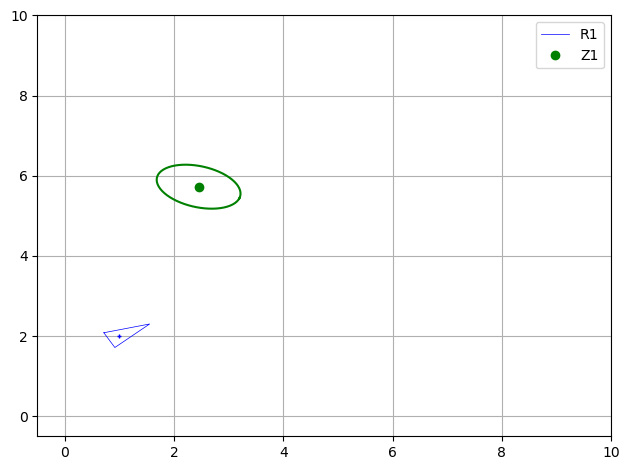

In [4]:
# Robot
p1_w = np.vstack([1, 2, 0.5]) # Robot R1 pose
Qp1_w = np.zeros((3, 3)) # Robot pose convariance matrix (uncertainty)

# Landmark observation
z1_p_r = np.vstack([4., .7]) # Measurement/Observation
W1 = np.diag([0.25, 0.04]) # Sensor noise covariance

# Express the landmark observation in the world frame (mean and covariance)
z1_w, Wz1 = to_world_frame(p1_w, Qp1_w, z1_p_r, W1)

# Visualize the results
fig, ax = plt.subplots()
plt.xlim([-.5, 10])
plt.ylim([-.5, 10])
plt.grid()
plt.tight_layout()

DrawRobot(fig, ax, p1_w, label='R1', color='blue')
    
ax.plot(z1_w[0, 0], z1_w[1, 0], 'o', label='Z1', color='green')
PlotEllipse(fig, ax, z1_w, Wz1, color='green')

plt.legend()
print('----\tExercise 4.1.1\t----\n'+
      'z1_w = {}\'\n'.format(z1_w.flatten())
      + 'Wz1_w = \n{}\n'.format(Wz1))

<span style="color:blue">Expected results for demo:</span>


```
---- Exercise 4.1.1 ----
z1_w = [2.44943102 5.72815634]'
Wz1_w = 
[[ 0.58879177 -0.13171532]
 [-0.13171532  0.30120823]]
```

2. **Añadiendo incertidumbre a la posición del robot.** Ahora, supongamos que la pose del robot no se conoce, sino que es una variable aleatoria que sigue una distribución de probabilidad gaussiana: $p_1 \sim N([1, 2, 0.5]^T, \Sigma_1)$ con $\Sigma_1 = \text{diag}([0.08,0.6, 0.02 ])$.

    1. Calcula la matriz de covarianza $\Sigma_{m1}$ del punto de referencia en el marco de referencia del mundo y trázala como una elipse centrada en la media $m_1$ (en azul). También traza la covarianza de la pose del robot (en azul.
    
    2. Compara la covarianza con la obtenida en el caso anterior. ¿Es mayor? ¿Es mayor que la del robot? ¿Por qué? **<span style="color:orangered">Comenta esto en las conclusiones de la práctica</span>**
     


---- Exercise 4.1.2 ----
Wz1_w = 
[[ 0.94677477 -0.23978943]
 [-0.23978943  0.94322523]]



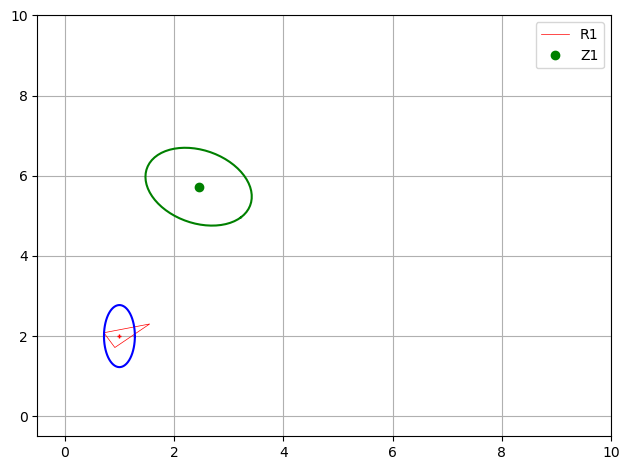

In [5]:
# Robot
p1_w = np.vstack([1, 2, 0.5]) # Robot R1 pose
Qp1_w = np.diag([0.08,0.6,0.02])  # Robot pose convariance matrix (uncertainty)

# Landmark observation
z1_p_r = np.vstack([4., .7]) # Measurement/Observation
W1 = np.diag([0.25, 0.04]) # Sensor noise covariance

# Express the landmark observation in the world frame (mean and covariance)
z1_w, Wz1 = to_world_frame(p1_w, Qp1_w, z1_p_r, W1)

# MATPLOTLIB
fig, ax = plt.subplots()
plt.xlim([-.5, 10])
plt.ylim([-.5, 10])
plt.grid()
plt.tight_layout()

fig.canvas.draw()

DrawRobot(fig, ax, p1_w, label='R1', color='red')  
PlotEllipse(fig, ax, p1_w,Qp1_w, color='blue')

ax.plot(z1_w[0, 0], z1_w[1, 0], 'o', label='Z1', color='green')
PlotEllipse(fig, ax, z1_w, Wz1, color='green')

plt.legend()
print('---- Exercise 4.1.2 ----\n'+
      'Wz1_w = \n{}\n'.format(Wz1))


<span style="color:blue">Expected results for demo:</span>

```
---- Exercise 4.1.2 ----
Wz1_w = 
[[ 0.94677477 -0.23978943]
 [-0.23978943  0.94322523]]
```

3. **Obteniendo la pose relativa entre dos robots**. Otro robot `R2` se encuentra en la pose $p_2 \sim ([6\ \text{m}, 4\ \text{m}, 2.1\ \text{rad}]^T, \Sigma_2)$ con $\Sigma_2 = \text{diag}([0.20,0.09, 0.03])$. Traza la pose `p2` y su elipse (covarianza) en verde. Calcula la pose relativa `p12` entre `R1` y `R2`.

Esta pose relativa se puede obtener de dos maneras diferentes:
- A través de la composición de poses, pero usando $\ominus p1$ en lugar de $p1$. Implémentalo en ``inverse_composition1()``.

Media: 
 
 $$
 p12 = \ominus p1 \oplus p2 = f(\ominus p1, p2) = 
 \begin{bmatrix} 
  x_{\ominus p1} + x_{p2} cos \theta_{\ominus p1} - y_{p2} sin \theta_{\ominus p1} \\
  y_{\ominus p1} + x_{p2} sin \theta_{\ominus p1} + y_{p2} cos \theta_{\ominus p1} \\
  \theta_{\ominus p1} + \theta_{p2}
 \end{bmatrix}
 $$
 
 Covarianza:
 
 $$
 \Sigma_{p12} = \frac{\partial p12}{\partial \ominus p1} \frac{\ominus p1}{\partial p1} \Sigma_{p1} \frac{\ominus p1}{\partial p1}^T \frac{\partial p12}{\partial \ominus p1}^T 
 +
 \frac{\partial p12}{\partial p2} \Sigma_{p2}  \frac{\partial p12}{\partial p2}^T
 \\
 \text{Aplicando la regla de la cadena} \rightarrow \Sigma_{p12} = \frac{\partial p12}{\partial \ominus p1} \Sigma_{\ominus p1} \frac{\partial p12}{\partial \ominus p1}^T
 +
 \frac{\partial p12}{\partial p2} \Sigma_{p2}  \frac{\partial p12}{\partial p2}^T
 $$
 
 Donde:
 
 $$
 \frac{\partial p12}{\partial \ominus p1} = 
 \begin{bmatrix}
 1 & 0 & -x_{p2} sin \theta_{\ominus p1} - y_{p2} cos \theta_{\ominus p1} \\
 0 & 1 & x_{p2} cos \theta_{\ominus p1} - y_{p2} sin \theta_{\ominus p1} \\
 0 & 0 & 1
 \end{bmatrix}  
 \; \; \; \; \; \frac{\partial p12}{\partial p2} = 
 \begin{bmatrix}
cos \theta_{\ominus p1} & -sin \theta_{\ominus p1} & 0\\
sin \theta_{\ominus p1} & cos \theta_{\ominus p1} & 0\\
 0 & 0 & 1
 \end{bmatrix}
 \\
 \frac{\partial \ominus p1}{\partial p1} = 
 \begin{bmatrix}
 -cos \theta_{p1} & -sin \theta_{p1} & x_{p1} sin \theta_{p1} - y_{p1} cos \theta_{p1} \\
 sin \theta_{p1} & -cos \theta_{p1} & x_{p1} cos \theta_{p1} + y_{p1} sin \theta_{p1}\\
 0 & 0 & -1 \\
 \end{bmatrix}
 \; \; \; \; \; \Sigma_{\ominus p1} = \frac{\partial \ominus p1}{\partial p1} \Sigma_{p1} \frac{\partial \ominus p1}{\partial p1}^T
 $$ 

- Utilizando la composición inversa de poses. Esta se proporciona en ``inverse_composition2()``.

In [6]:
def inverse_composition1(p1_w, Qp1_w, p2_w, Qp2_w):
    jac_inv_p = jac_tinv(p1_w)

    inv_r1 = (
        tinv(p1_w),
        jac_inv_p @ Qp1_w @ jac_inv_p.T
    )

    jac_p12_inv = J1(inv_r1[0], p2_w)
    jac_p12_p2 = J2(inv_r1[0], p2_w)

    p12_w = tcomp(tinv(p1_w), p2_w)
        
    Qp12_w = (
            jac_p12_inv@inv_r1[1]@jac_p12_inv.T
            + jac_p12_p2@Qp2_w@jac_p12_p2.T
        )
    
    return p12_w, Qp12_w

In [7]:
def inverse_composition2(p1_w, Qp1_w, p2_w, Qp2_w):
    dx, dy = p2_w[0, 0]-p1_w[0, 0], p2_w[1, 0]-p1_w[1, 0]
    a = p2_w[2, 0] - p1_w[2, 0]
    c, s = np.cos(p1_w[2, 0]), np.sin(p1_w[2, 0])

    p12_w = np.array([
        [dx*c + dy*s],
        [-dx*s + dy*c],
        [a]])
    
    jac_p12_r1 = np.array([
        [-c, -s, -dx*s + dy*c],
        [s, -c, -dx*c - dy*s],
        [0, 0, -1]
    ])

    jac_p12_r2 = np.array([
        [c, s, 0],
        [-s, c, 0],
        [0, 0, -1]
    ])

    #jac_p1_pinv = np.linalg.inv(jac_tinv(r1[0]))

    Qp12_w = jac_p12_r1@Qp1_w@jac_p12_r1.T + jac_p12_r2@Qp2_w@jac_p12_r2.T

    return p12_w, Qp12_w

In [8]:
# Robot R1
p1_w = np.vstack([1., 2., 0.5])
Qp1_w = np.diag([0.08, 0.6, 0.02])

# Robot R2
p2_w = np.vstack([6., 4., 2.1])
Qp2_w = np.diag([0.20, 0.09, 0.03])

# Obtain the relative pose p12 between both robots through the composition of poses
p12_w, Qp12_w = inverse_composition1(p1_w, Qp1_w, p2_w, Qp2_w)
print( '----\tExercise 4.1.3 with method 1\t----\n'+
        'p12_w = {}\'\n'.format(p12_w.flatten())+
        'Qp12_w = \n{}\n'.format(Qp12_w))

# Obtain the relative pose p12 between both robots through the inverse composition of poses
p12_w, Qp12_w = inverse_composition2(p1_w, Qp1_w, p2_w, Qp2_w)
print( '----\tExercise 4.1.3 with method 2\t----\n'+
        'p12_w = {}\'\n'.format(p12_w.flatten())+
        'Qp12_w = \n{}\n'.format(Qp12_w))

----	Exercise 4.1.3 with method 1	----
p12_w = [ 5.34676389 -0.64196257  1.6       ]'
Qp12_w = 
[[0.38248035 0.24115    0.01283925]
 [0.24115    1.16751965 0.10693528]
 [0.01283925 0.10693528 0.05      ]]

----	Exercise 4.1.3 with method 2	----
p12_w = [ 5.34676389 -0.64196257  1.6       ]'
Qp12_w = 
[[0.38248035 0.24115    0.01283925]
 [0.24115    1.16751965 0.10693528]
 [0.01283925 0.10693528 0.05      ]]



<span style="color:blue">Expected results:</span>
 ```
 p12_w = [ 5.34676389 -0.64196257  1.6       ]'
 
 Qp12_w = 
 [[0.38248035 0.24115    0.01283925]
 [0.24115    1.16751965 0.10693528]
 [0.01283925 0.10693528 0.05      ]]
 ```

4. **Prediciendo una observación desde el segundo robot.** Según la información proporcionada por $R1$ sobre la posición del punto de referencia $m$ en las coordenadas del mundo (su ubicación es $z_{1\_w}$) y su incertidumbre asociada $W_{z_1\_w}$), calcula la *distribución de la observación predecida* de $z_{2p} =[r, \alpha] \sim N(z_{2p}, W_{2p})$ como si se tomara con un sensor de rango y orientación montado en $R2$.

Considera lo siguiente:

- El modelo de medición es *(Notas: utiliza ``np.arctan2()`` para calcular el ángulo. En este punto, ignora el ruido $w_i$)*:
 
 $$
 z_i = \begin{bmatrix} r_i \\ \alpha_i \end{bmatrix} = h(x,m_i) + w_i = 
 \begin{bmatrix} \sqrt((x_i-x)^2+(y_i-y)^2) \\ atan(\frac{y_i-y}{x_i-x}) - \theta \end{bmatrix} 
 + w_i
 $$
 
- Necesitamos calcular la covarianza de la observación predecida en coordenadas polares $(W_{2p})$. Para eso, utiliza el siguiente jacobiano:

 $$
     \frac{\partial{p}}{\partial{c}} = 
     \begin{bmatrix}
         \cos{(\alpha+\theta)}  & \sin{(\alpha+\theta)} \\
         -\sin{(\alpha+\theta)} / r  & \cos{(\alpha+\theta)} / r
     \end{bmatrix}
 $$

In [9]:
def predicted_obs_from_pov(p1_w, z1_w, Wz1_w):
    """ Method to translate a pose+covariance in the world frame to an observation.
    
        This method only translated the landmark to the pov of the robot.
        It does not simulate a new observation.
        
        Args:
            p1_w: Pose of the robot which acts as pov
            z1_w: Landmark observed in cartesian coordinates(world frame)
            Wz1_w: Covariance associated to the landmark.
        Returns:
            z2_pr: Expected observation of z1 from pov of p1_w
            W2_p: Covariance associated to z2_pr
    """
    xi,yi,ti = p1_w[0,0], p1_w[1,0], p1_w[2,0]
    x,y =z1_w[0],z1_w[1]
    # Take a measurement using the range-bearing model
    z2_pr = np.vstack([
            [np.sqrt((xi-x)**2+(yi-y)**2)], # distance
            [np.arctan2((y-yi),(x-xi))-ti]# angle
        ])
      
    # Jacobian from cartesian to polar at z2p_r when the covariance is in
    # global coordianes
    theta = z2_pr[1, 0] + p1_w[2, 0] 
    s, c = np.sin(theta), np.cos(theta)
    r = z2_pr[0, 0]

    Jac_car_pol = np.array([
        [c, s],
        [-s/r, c/r]
    ])

    # Finally, propagate the uncertainty to polar coordinates in the
    # robot frame
    W2_p = Jac_car_pol@Wz1_w@Jac_car_pol.T
    
    
    return z2_pr, W2_p

In [10]:
p2_w = np.vstack([6., 4., 2.1])

z2_pr, W2_p = predicted_obs_from_pov(p2_w, z1_w, Wz1)
print( '---- Exercise 4.1.4 ----\n'+
    'z2p_r = {}\'\n'.format(z2_pr.flatten())+
    'W2_p = \n{}\n'.format(W2_p)    
)

---- Exercise 4.1.4 ----
z2p_r = [3.94880545 0.58862004]'
W2_p = 
[[ 1.13481128 -0.03710981]
 [-0.03710981  0.04843106]]



<span style="color:blue">Expected output:</span>
```
---- Exercise 4.1.4 ----
z2p_r = [3.94880545 0.58862004]'
W2_p = 
[[ 1.13481128 -0.03710981]
 [-0.03710981  0.04843106]]
```

5. **Combinando observaciones para el mismo punto de referencia.** Supongamos ahora que se toma una medición $z_2 = [4 m., 0.3 rad.]^T$ del punto de referencia $m$ desde $R2$ con un sensor que tiene la misma precisión que el de $R1$ ($W_{2p}= W_{1p}$).

1. ¿Cuál es la función de densidad de probabilidad (pdf) del punto de referencia observado según esta nueva medición? Dibuja la elipse correspondiente (en verde).
2. Ahora hay dos pdf diferentes asociadas al mismo punto de referencia.
    1. ¿Es eso una contradicción?
    2. ¿Puedes idear una solución que combine estas dos "piezas de información"? Dibuja la elipse en rojo. **<span style="color:orangered">Comenta tu solución en las conclusiones de la práctica</span>**.
     
    
<figure style="text-align:center">
  <img src="images/fig4-1-2.png" width="400" alt="">
  <figcaption>Fig. 2: Resultados del último ejercicio </figcaption>
</figure>    

In [16]:
def combine_pdfs(z1_w, Wz1_w, z2_w, Wz2_w):
    """ Method to combine the pdfs associated with two observations of the same landmark.  
        
        Args:            
            z1_w: Landmark observed in cartesian coordinates(world frame) from Robot 1
            Wz1_w: Covariance associated to the landmark.
            z2_w: Landmark observed in cartesian coordinates(world frame) from Robot 2
            Wz2_w: Covariance associated to the landmark.
        Returns:
            z: Combined observation
            W_z: Uncertainty associated to z
    """
    invs1 = np.linalg.inv(Wz1_w) # Hint use linalg.inv
    invs2 = np.linalg.inv(Wz2_w)

    invs3 = invs1 + invs2
    mean3 = np.linalg.inv(invs3) @ ((invs1 @ z1_w) + (invs2 @ z2_w))   # Hint: use the @ operator

    W_z = np.linalg.inv(invs3)
    z = mean3

    return z, W_z
    

----	Exercise 4.1.5	----
z2_w = [3.05042514 6.70185272]'
Qz2 = 
[[0.84693794 0.4333316 ]
 [0.4333316  0.81306206]]

----	Exercise 4.1.5 parte 2	----
z_w = [2.58757252 6.15534036]'
Wz_w = 
[[0.37966125 0.07773125]
 [0.07773125 0.36999739]]



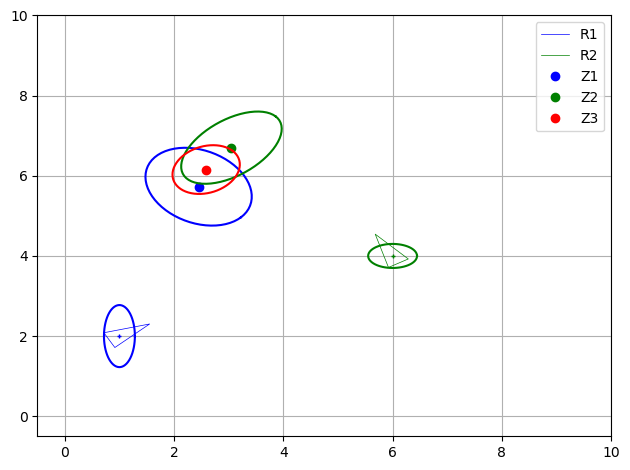

In [17]:
z2_p_r = np.vstack([4., .3])
Wz2_p_r = np.diag([0.25, 0.04])

z1_w, Qz1 = to_world_frame(p1_w, Qp1_w, z1_p_r, W1)
z2_w, Qz2 = to_world_frame(p2_w, Qp2_w, z2_p_r, Wz2_p_r)

# Show results
fig, ax = plt.subplots()
plt.xlim([-.5, 10])
plt.ylim([-.5, 10])
plt.grid()
plt.tight_layout()

fig.canvas.draw()

DrawRobot(fig, ax, p1_w, label='R1', color='blue')
PlotEllipse(fig, ax, p1_w, Qp1_w, color='blue')

DrawRobot(fig, ax, p2_w, label='R2', color='green')
PlotEllipse(fig, ax, p2_w, Qp2_w, color='green')
   
ax.plot(z1_w[0, 0], z1_w[1, 0], 'o', label='Z1', color='blue')
PlotEllipse(fig, ax, z1_w, Qz1, color='blue')
          
ax.plot(z2_w[0, 0], z2_w[1, 0], 'o', label='Z2', color='green')
PlotEllipse(fig, ax, z2_w, Qz2, color='green')

z_w, Wz_w = combine_pdfs(z1_w, Qz1, z2_w, Qz2)
ax.plot(z_w[0, 0], z_w[1, 0], 'o', label='Z3', color='red')
PlotEllipse(fig, ax, z_w, Wz_w, color='red')
          
plt.legend()

# Print results
print( '----\tExercise 4.1.5\t----\n'+
    'z2_w = {}\'\n'.format(z2_w.flatten())+
    'Qz2 = \n{}\n'.format(Qz2)
    )

# Print results
print( '----\tExercise 4.1.5 parte 2\t----\n'+
    'z_w = {}\'\n'.format(z_w.flatten())+
    'Wz_w = \n{}\n'.format(Wz_w)
    )

<span style="color:blue">Expected ouputs:</span>

### Sensor measurement from R2

```
z2_w = [3.05042514 6.70185272]'
Qz2 = 
[[0.84693794 0.4333316 ]
 [0.4333316  0.81306206]]
```

### Combined information
```
---- Exercise 4.1.5 parte 2 ----
z_w = [2.58757252 6.15534036]'
Wz_w = 
[[0.37966125 0.07773125]
 [0.07773125 0.36999739]]
```

## Conclusiones de la práctica
En la celda a continuación, discute lo que se ha hecho en el cuaderno, lo que has encontrado interesante o cualquier otro pensamiento relevante.

<span style="color:orangered">***Escribe tu respuesta aquí***</span>

En esta práctica hemos profundizado aun más en el posicionamiento de un robot con incertidumbre utilizando no sólo la información del propio robot sino la varios posibles robot referencia. Esto, añadido al conocimiento estadístico de la primera práctica, permite dar una aproximación mucho más cercana del robot.